In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal

from seiz_eeg.dataset import EEGDataset

import torch
import torch.nn as nn
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import MessagePassing, global_mean_pool

import os
import random

from sklearn.metrics import f1_score, recall_score, precision_score

from tqdm import tqdm

/Users/tugba/Desktop/EPFL/ee452-nml/.venv/lib/python3.10/site-packages/pandera/_pandas_deprecated.py:157: FutureWarning: Importing pandas-specific classes and functions from the
top-level pandera module will be **removed in a future version of pandera**.
If you're using pandera to validate pandas objects, we highly recommend updating
your import:

```
# old import
import pandera as pa

# new import
import pandera.pandas as pa
```

If you're using pandera to validate objects from other compatible libraries
like pyspark or polars, see the supported libraries section of the documentation
for more information on how to import pandera:

https://pandera.readthedocs.io/en/stable/supported_libraries.html

To disable this warning, set the environment variable:

```
export DISABLE_PANDERA_IMPORT_WARNING=True
```

  warnings.warn(_future_warning, FutureWarning)


In [2]:
data_path = "./data"

DATA_ROOT = Path(data_path)

In [3]:
# Load your CSV file
df = pd.read_csv(DATA_ROOT / "distances_3d.csv")  # Update with your actual file path

# Get sorted list of unique node names (e.g., 'FP1', 'F3', ...)
nodes = sorted(set(df["from"]) | set(df["to"]))
node_to_idx = {name: idx for idx, name in enumerate(nodes)}

# Create empty matrix
N = len(nodes)
dist = np.full((N, N), np.inf)  # Initialize with inf (or large number)

# Fill matrix
for _, row in df.iterrows():
    i = node_to_idx[row["from"]]
    j = node_to_idx[row["to"]]
    dist[i, j] = float(row["distance"])

In [134]:
def build_softmax_thresholded_graph(dist, beta=10.0, keep_ratio=0.9):
    N = dist.shape[0]
    edge_index = []
    edge_attr = []
    added = set()

    for i in range(N):
        scores = -beta * (dist[i] ** 2)
        scores[i] = -np.inf
        weights = np.exp(scores)
        weights /= weights.sum()

        if keep_ratio == 1.0:
            keep = [j for j in range(N) if j != i]
        else:
            sorted_idx = np.argsort(-weights)
            cumulative = np.cumsum(weights[sorted_idx])
            cutoff = np.searchsorted(cumulative, keep_ratio) + 1
            keep = sorted_idx[:cutoff]

        for j in keep:
            if i != j and (i, j) not in added:
                edge_index.append([i, j])
                edge_attr.append(weights[j])
                # Add reverse edge (j, i) with same weight
                edge_index.append([j, i])
                edge_attr.append(weights[j])
                added.add((i, j))
                added.add((j, i))

    edge_index = torch.tensor(edge_index, dtype=torch.long).T  # shape [2, num_edges]
    edge_attr = torch.tensor(edge_attr, dtype=torch.float32)   # shape [num_edges]
    return edge_index, edge_attr



In [135]:
edge_index, edge_attr = build_softmax_thresholded_graph(dist, beta=5, keep_ratio=0.9)

In [136]:
def seed_everything(seed: int):
    # Python random module
    random.seed(seed)
    # Numpy random module
    np.random.seed(seed)
    # Torch random seeds
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.

    # Set PYTHONHASHSEED environment variable for hash-based operations
    os.environ["PYTHONHASHSEED"] = str(seed)

    # Ensure deterministic behavior in cudnn (may slow down your training)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


seed_everything(1)

In [137]:
bp_filter = signal.butter(4, (0.5, 30), btype="bandpass", output="sos", fs=250)


def time_filtering(x: np.ndarray) -> np.ndarray:
    """Filter signal in the time domain"""
    return signal.sosfiltfilt(bp_filter, x, axis=0).copy()


def fft_filtering(x: np.ndarray) -> np.ndarray:
    """Compute FFT and only keep"""
    x = np.abs(np.fft.fft(x, axis=0))
    x = np.log(np.where(x > 1e-8, x, 1e-8))

    win_len = x.shape[0]
    # Only frequencies b/w 0.5 and 30Hz
    return x[int(0.5 * win_len // 250) : 30 * win_len // 250]

In [146]:
from scipy import signal
from scipy.stats import skew, kurtosis
import numpy as np

fs = 250 # Sampling frequency

bp_filter = signal.butter(4, (0.5, 30), btype="bandpass", output="sos", fs=fs)

def handcrafted_features(x: np.ndarray) -> np.ndarray:

    mean_abs_diff1 = np.mean(np.abs(x[1:] - x[:-1]), axis=0)
    mean_abs_diff2 = np.mean(np.abs(x[2:] - x[:-2]), axis=0)
    std      = np.std(x, axis=0)
    skewness = np.nan_to_num(skew(x, axis=0), nan=0.0)
    kurt     = np.nan_to_num(kurtosis(x, axis=0), nan=0.0)

    fft_vals = np.abs(np.fft.rfft(x, axis=0))
    freqs = np.fft.rfftfreq(x.shape[0], d=1/fs)
    '''
    fft_vals = np.abs(np.fft.fft(x, axis=0))
    fft_vals_log = np.log(np.where(fft_vals > 1e-8, fft_vals, 1e-8))

    win_len = fft_vals.shape[0]

    fft_vals_filtered = fft_vals_log[int(0.5 * win_len // 250) : 30 * win_len // 250]

    fft_bins = []
    prev_idx = 0
    next_idx = 6

    while next_idx <= fft_vals_filtered.shape[0]:
        fft_bins.append(np.mean(fft_vals_filtered[prev_idx:next_idx], axis=0))
        prev_idx = next_idx
        next_idx += 12

    fft_bins = np.array(fft_bins)

    def band_power(fmin, fmax):
        return np.sum(fft_vals[int(fmin * win_len // 250) : fmax * win_len // 250], axis=0)
    '''

    def band_power(fmin, fmax):
        idx = np.where((freqs >= fmin) & (freqs <= fmax))[0]
        return np.mean(fft_vals[idx], axis=0)


    delta = band_power(0.5, 4)
    theta = band_power(4, 8)
    alpha = band_power(8, 13)
    beta  = band_power(13, 30)

    total_power = np.sum(fft_vals, axis=0)

    # Avoid division by zero
    relative_delta = np.divide(delta, total_power, out=np.zeros_like(delta), where=total_power != 0)
    relative_theta = np.divide(theta, total_power, out=np.zeros_like(theta), where=total_power != 0)
    relative_alpha = np.divide(alpha, total_power, out=np.zeros_like(alpha), where=total_power != 0)
    relative_beta  = np.divide(beta,  total_power, out=np.zeros_like(beta),  where=total_power != 0)


    def hjorth_params(x_channel):
        dx = np.diff(x_channel)
        ddx = np.diff(dx)
        var_x = np.var(x_channel)
        var_dx = np.var(dx)
        var_ddx = np.var(ddx)
        mobility = np.sqrt(var_dx / var_x) if var_x != 0 else 0
        complexity = np.sqrt(var_ddx / var_dx) / mobility if var_dx != 0 and mobility != 0 else 0
        return mobility, complexity

    mobility = np.zeros(x.shape[1])
    complexity = np.zeros(x.shape[1])
    for i in range(x.shape[1]):
        mobility[i], complexity[i] = hjorth_params(x[:, i])

    zero_crossings = np.sum(np.abs(np.diff(np.signbit(x), axis=0)), axis=0)

    def shannon_entropy(signal):
        hist, _ = np.histogram(signal, bins=50, density=True)
        hist += 1e-12
        return -np.sum(hist * np.log2(hist))

    entropy = np.array([shannon_entropy(x[:, i]) for i in range(x.shape[1])])

    psd = fft_vals / (np.sum(fft_vals, axis=0, keepdims=True) + 1e-12)
    spectral_entropy = -np.sum(psd * np.log2(psd + 1e-12), axis=0)

    fft_result = fft_filtering(x)

    features = np.concatenate([
        fft_result.T, # shape (19, 354)
        mean_abs_diff1[:, None],
        mean_abs_diff2[:, None],
        std[:, None],
        skewness[:, None],
        kurt[:, None],
        delta[:, None], theta[:, None], alpha[:, None], beta[:, None],
        relative_delta[:, None], relative_theta[:, None], relative_alpha[:, None], relative_beta[:, None],
        mobility[:, None], complexity[:, None],
        zero_crossings[:, None],
        entropy[:, None],
        spectral_entropy[:, None],
    ], axis=1).T


    #features = (features - np.mean(features, axis=1, keepdims=True)) / (np.std(features, axis=1, keepdims=True) + 1e-8)
    return features

In [147]:
clips_tr = pd.read_parquet(DATA_ROOT / "train/segments.parquet")
dataset_tr = EEGDataset(
    clips_tr,
    signals_root=DATA_ROOT / "train",
    signal_transform=handcrafted_features,
    prefetch=True,  # If your compute does not allow it, you can use `prefetch=False`
)

In [148]:
dataset_tr[0][0].shape

(372, 19)

In [149]:
class EEGGraphDataset(Dataset):
    def __init__(self, data, edge_index, edge_attr, is_train=True):
        super().__init__()
        self.num_samples = len(data)
        self.edge_index = edge_index
        self.edge_attr = edge_attr
        self.data = data
        self.is_train = is_train

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        x = torch.tensor(self.data[idx][0].T, dtype=torch.float32)  # Simulated signal
        y = int(self.data[idx][1]) # Target label if training, else ID
        if self.is_train:
            return Data(x=x, edge_index=self.edge_index, edge_attr=self.edge_attr, y=torch.tensor([[y]], dtype=torch.float32))
        else:
            return Data(x=x, edge_index=self.edge_index, edge_attr=self.edge_attr, id=y)

In [150]:
from torch_geometric.utils import softmax
class DistanceMPNNLayer(MessagePassing):
    def __init__(self, in_channels, hidden_channels):
        super().__init__(aggr='mean')  # sum aggregation
        self.mlp_msg = nn.Sequential(
            nn.Linear(in_channels, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, hidden_channels),
        )
        self.att_mlp = nn.Sequential(
            nn.Linear(2 * in_channels, 1)  # computes raw attention score
        )
        self.mlp_update = nn.Sequential(
            nn.Linear(in_channels + hidden_channels, hidden_channels),
            nn.LayerNorm(hidden_channels),
            nn.ReLU()
        )
        self.norm = nn.LayerNorm(hidden_channels)

    def forward(self, x, edge_index):
        return self.mlp_update(torch.cat([x, self.propagate(edge_index=edge_index, x=x)], dim=-1))

    def message(self, x_i, x_j, index):
        # Compute attention scores from concatenated [x_i || x_j]
        att_input = torch.cat([x_i, x_j], dim=-1)
        att_scores = self.att_mlp(att_input).squeeze(-1)

        # Softmax normalization per target node (index)
        att_weights = softmax(att_scores, index)

        # Compute message ψ(X_j) and weight it by attention α
        return att_weights.view(-1, 1) * self.mlp_msg(x_j)



class DistanceMPNN(nn.Module):
    def __init__(self, in_channels, hidden_channels_1, hidden_channels_2, hidden_channels_3):
        super().__init__()
        self.first = DistanceMPNNLayer(in_channels, hidden_channels_1)
        self.second = DistanceMPNNLayer(hidden_channels_1, hidden_channels_2)
        self.third = DistanceMPNNLayer(hidden_channels_2, hidden_channels_3)
        self.final_mlp = nn.Linear(hidden_channels_3, 1)


    def forward(self, x, edge_index, edge_attr, batch):
        return self.final_mlp(global_mean_pool(self.third(self.second(self.first(x, edge_index), edge_index),edge_index), batch))

In [151]:
from torch.utils.data import random_split

total_len = len(dataset_tr)
train_len = int(0.8 * total_len)
val_len = total_len - train_len

# Randomly split
dataset_tr_split, dataset_val_split = random_split(dataset_tr, [train_len, val_len])


In [152]:
# Now wrap both in EEGGraphDataset
train_dataset = EEGGraphDataset(dataset_tr_split, edge_index=edge_index, edge_attr=edge_attr, is_train=True)
val_dataset = EEGGraphDataset(dataset_val_split, edge_index=edge_index, edge_attr=edge_attr, is_train=True)

In [158]:
labels = [int(train_dataset[i].y.item()) for i in range(len(train_dataset))]

num_pos = sum(labels)
num_neg = len(labels) - num_pos

class_weights = [1.0 / num_pos if l == 1 else 1.0 / num_neg for l in labels]

from torch.utils.data import WeightedRandomSampler

sampler = WeightedRandomSampler(class_weights, num_samples=len(class_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)


In [160]:
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DistanceMPNN(in_channels=dataset_tr[0][0].shape[0], hidden_channels_1=128, hidden_channels_2=64, hidden_channels_3=16).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

criterion = nn.BCEWithLogitsLoss()

train_losses = []
val_losses = []

for epoch in range(1000):
    model.train()
    total_train_loss = 0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        logits = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
        loss = criterion(logits, batch.y)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    total_val_loss = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)
            logits = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).float()

            # Flatten and collect predictions and labels
            all_preds.extend(preds.cpu().numpy().flatten())
            all_labels.extend(batch.y.view(-1).cpu().numpy())
    f1 = f1_score(all_labels, all_preds)
    val_losses.append(f1)

    print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val F1 Score: {f1:.4f}")



Epoch 1, Train Loss: 0.5763, Val F1 Score: 0.5316
Epoch 2, Train Loss: 0.5017, Val F1 Score: 0.6114
Epoch 3, Train Loss: 0.4788, Val F1 Score: 0.6118
Epoch 4, Train Loss: 0.4661, Val F1 Score: 0.6133
Epoch 5, Train Loss: 0.4507, Val F1 Score: 0.5367
Epoch 6, Train Loss: 0.4331, Val F1 Score: 0.6325
Epoch 7, Train Loss: 0.4162, Val F1 Score: 0.6284
Epoch 8, Train Loss: 0.4188, Val F1 Score: 0.6091
Epoch 9, Train Loss: 0.3994, Val F1 Score: 0.6369
Epoch 10, Train Loss: 0.4079, Val F1 Score: 0.6272
Epoch 11, Train Loss: 0.3943, Val F1 Score: 0.5976
Epoch 12, Train Loss: 0.3876, Val F1 Score: 0.6481
Epoch 13, Train Loss: 0.3721, Val F1 Score: 0.5892
Epoch 14, Train Loss: 0.3732, Val F1 Score: 0.6643
Epoch 15, Train Loss: 0.3607, Val F1 Score: 0.6586
Epoch 16, Train Loss: 0.3697, Val F1 Score: 0.6613
Epoch 17, Train Loss: 0.3484, Val F1 Score: 0.6454
Epoch 18, Train Loss: 0.3496, Val F1 Score: 0.6795
Epoch 19, Train Loss: 0.3525, Val F1 Score: 0.6724
Epoch 20, Train Loss: 0.3377, Val F1 Sco

KeyboardInterrupt: 

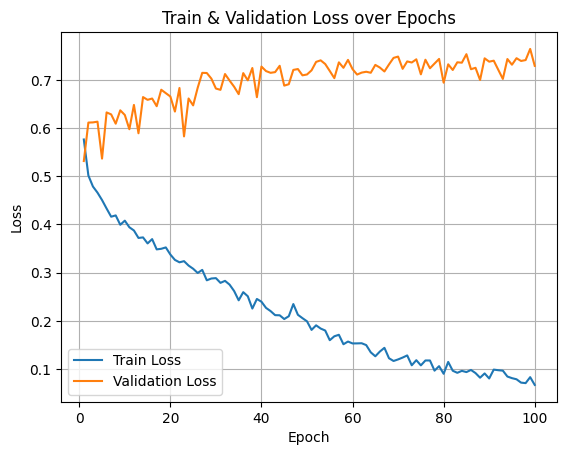

In [161]:
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss")
plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train & Validation Loss over Epochs")
plt.legend()
plt.grid(True)
plt.show()

In [162]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for batch in train_loader:
        batch = batch.to(device)
        logits = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
        preds = torch.sigmoid(logits)
        predicted_labels = (preds > 0.5).float()

        correct += (predicted_labels == batch.y).sum().item()
        total += batch.y.size(0)

train_accuracy = correct / total
print(f"Train Accuracy: {train_accuracy:.4f}")


Train Accuracy: 0.9641


In [166]:
from sklearn.metrics import f1_score, recall_score, precision_score

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in val_loader:
        batch = batch.to(device)
        logits = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
        probs = torch.sigmoid(logits)
        preds = (probs > 0.6).float()

        # Flatten and collect predictions and labels
        all_preds.extend(preds.cpu().numpy().flatten())
        all_labels.extend(batch.y.view(-1).cpu().numpy())  # ensure 1D

# Compute F1 score
f1 = f1_score(all_labels, all_preds)


print(f"Validation F1 Score: {f1:.4f}")


Validation F1 Score: 0.7385


In [167]:
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score
recall = recall_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
accuracy = accuracy_score(all_labels, all_preds)

print(f"Validation Recall: {recall:.4f}")
print(f"Validation Precision: {precision:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

Validation Recall: 0.7421
Validation Precision: 0.7349
Validation Accuracy: 0.8973
